In [3]:
#Compute RMS of the errors in plot 3

In [4]:
import numpy as np
import xarray as xr
from distributed import Client
import dask_jobqueue
#import dask
#import daskdataframe as dd
import matplotlib.pyplot as plt
import glob
import netCDF4 as nc
import zarr
import nc_time_axis
import xskillscore as xs
import cartopy as cart
import matplotlib.colors as mcolors
import matplotlib.cm as cm
#%run data_handler.ipynb
#np.set_printoptions(threshold=np.inf)
#import statsmodels.api as sm

In [5]:
# #Chicago
# LAT        = 41.8781
# LON        = 360-87.6298
# # #Bengaluru:
LAT        = 12.9716
LON        = 77.5946
########## CONUS ############
#CONUS lat-lon
top     = 50.0 # north lat
left    = -124.7844079+360 # west long
right   = -66.9513812+360 # east long
bottom  =  24.7433195 # south lat
################################
cesm2_path = '/global/scratch/users/harsha/LENS/cesm2/tasmax/'
cvals      = '/global/scratch/users/harsha/LENS/cesm2/cvals/'
loc        = 'Bengaluru/'
locn       = 'Bengaluru'
cvals1     = '/global/scratch/users/harsha/LENS/cesm2/tmax_mem'
## Change/Check these parameters before running
season     = 'JJA'
season0    = 'jja'
months     = [6,7,8]
day        =  211          #First day of the season
Day        = 'Jul'

In [6]:
job_extra = ['--qos=cf_lowprio','--account=ac_cumulus'] 
#job_extra =['--qos=lr6_lowprio','--account=ac_cumulus','--constraint=lr6_m192']
#job_extra =['--qos=lr_lowprio','--account=ac_cumulus']
cluster = dask_jobqueue.SLURMCluster(queue="cf1", cores=10, walltime='6:00:00', 
                local_directory='/global/scratch/users/harsha/dask_space/', 
                log_directory='/global/scratch/users/harsha/dask_space/', 
                job_extra_directives=job_extra, interface='eth0', memory="192GB") 
client  = Client(cluster) 
cluster.scale_up(5)

In [7]:
cluster

In [8]:
pi_year0 = '1850'
pi_year1 = '1879'
ic_year0 = '1950'
ic_year1 = '1979'
#doy      = 211 # day_of_year
#date     = 'Jul30'

In [9]:
%%time
ds_ssp  = xr.open_mfdataset(cesm2_path+'ssp370_cesm2tmax.zarr',engine='zarr')
ds_hist = xr.open_mfdataset(cesm2_path+'bhist_cesm2tmax.zarr',engine='zarr')

CPU times: user 806 ms, sys: 99.2 ms, total: 905 ms
Wall time: 2.86 s


In [10]:
%%time
#t-temp, nw - no-warming, w-warming, hw = historical warming, g=global
tgw    = ds_ssp.TREFHTMX
         #.sel(lat=slice(bottom,top))
         #.sel(lon=slice(left,right))
tgnw   = ds_hist.TREFHTMX.sel(time=slice(pi_year0,pi_year1))
         #.sel(lon=slice(left,right)).sel(lat=slice(bottom,top))
tghw   = ds_hist.TREFHTMX
         #.sel(lat=slice(bottom,top))
         #.sel(lon=slice(left,right))
tgnw

CPU times: user 106 ms, sys: 3.02 ms, total: 109 ms
Wall time: 402 ms


,Array,Chunk
Bytes,225.56 GiB,769.92 MiB
Shape,"(10950, 192, 288, 100)","(3650, 192, 288, 1)"
Count,2001 Tasks,300 Chunks
Type,float32,numpy.ndarray


In [11]:
%%time
tgw_trim     = tghw.drop_isel({'time':-1}).sel(time=slice(ic_year0,ic_year1)) #Drop Jan 1, 2101 data
tghw_trim    = tghw.drop_isel({'time':-1}).sel(time=slice(pi_year0,pi_year1)) #Drop an extra copy of Jan 1, 2015 data
tgmw         = xr.concat([tghw_trim,tgw_trim],dim='time')
tgmw         = tgmw.chunk({'time':900,'lat':20,'lon':30,'member':100})   
tgmw

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]

CPU times: user 881 ms, sys: 82.5 ms, total: 963 ms
Wall time: 976 ms


,Array,Chunk
Bytes,451.13 GiB,205.99 MiB
Shape,"(21900, 192, 288, 100)","(900, 20, 30, 100)"
Count,52449 Tasks,2500 Chunks
Type,float32,numpy.ndarray


In [12]:
%%time
tgmw_season  = tgmw.sel(time=tgmw.time.dt.month.isin(months))
tgmw_season

CPU times: user 63.4 ms, sys: 1.78 ms, total: 65.2 ms
Wall time: 105 ms


/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


,Array,Chunk
Bytes,113.71 GiB,63.17 MiB
Shape,"(5520, 192, 288, 100)","(276, 20, 30, 100)"
Count,54949 Tasks,2500 Chunks
Type,float32,numpy.ndarray


In [13]:
def stacker(x):
    #Assumes that x has dimensions year and member
    x = x.stack(ym=('year','member'),create_index=False)
    return x
def stacker2(x):
    #Assumes that x has dimensions year and member
    x = x.stack(mtime=('year','member'),create_index=False)
    return x

In [14]:
def to_daily(ds):
    year = ds.time.dt.year
    day = ds.time.dt.dayofyear

    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), day=("time", day.data))

    # reshape the array to (..., "day", "year")
    return ds.set_index(time=("year", "day")).unstack("time")  

In [15]:
def stack_roll(ds,roll_len,stride_len):
    #Assumes that ds has dimensions year and member
    ds_stack   = stacker(ds)
    print(ds_stack)
    ds_roll    = ds_stack.rolling(ym=roll_len, center=True).construct('index', stride=stride_len)
    
    return ds_roll   

In [16]:
%%time
tgmw_dseason = to_daily(tgmw_season)
tgmw_dseason = tgmw_dseason.chunk({'year':60,'day':5})
tgmw_dseason

CPU times: user 449 ms, sys: 21.9 ms, total: 471 ms
Wall time: 469 ms


,Array,Chunk
Bytes,113.71 GiB,68.66 MiB
Shape,"(192, 288, 100, 60, 92)","(20, 30, 100, 60, 5)"
Count,81349 Tasks,1900 Chunks
Type,float32,numpy.ndarray


In [17]:
%%time
#Save files
dseason_path = cvals+'tgmw_hist_'+season0+'_daily'+'_'+pi_year0+'_'+ic_year1+'.zarr'
print(dseason_path)
# ##### season ###########
#tgmw_dseason.to_dataset().to_zarr(dseason_path,mode='w')

/global/scratch/users/harsha/LENS/cesm2/cvals/tgmw_hist_jja_daily_1850_1979.zarr
CPU times: user 53 µs, sys: 8 µs, total: 61 µs
Wall time: 62 µs


In [18]:
tgmw_dseason = xr.open_zarr(dseason_path)
tgmw_dseason = tgmw_dseason.TREFHTMX
tgmw_dseason

,Array,Chunk
Bytes,113.71 GiB,68.66 MiB
Shape,"(192, 288, 100, 60, 92)","(20, 30, 100, 60, 5)"
Count,1901 Tasks,1900 Chunks
Type,float32,numpy.ndarray


In [19]:
%%time
#Stack member and year into one dimension- 'ym'. Then, roll over this dimension \
# with stride = N_mem.
#This works because of the way xarray stacks two dimensions. window_len =30. 
#I have called the 'window' dimension 'index'.
quants             = np.arange(0,1.01,0.01)
#tgmw_djulstack     = tgmw_djul.stack(ym=('year','member'),create_index=False)
#tgmw_julrndrop    = stack_roll_ndrop(tgmw_djul,N_mem*window_len,N_mem,15,251-14)
########################
N_mem              = 100
window_len         = 30
###### season #######
#r = roll, ndrop = drop NANs
tgmw_seasonroll     = stack_roll(tgmw_dseason,N_mem*window_len,N_mem)
#########
#tgmw_djulconstruct = tgmw_djulstack.rolling(ym=N_mem*window_len, center=True)\
##.construct('index', stride=N_mem)
tgmw_seasonroll0   = tgmw_seasonroll.sel(ym=[15,45])  
tgmw_seasonroll0   = tgmw_seasonroll.sel(ym=[15,45])  
tgmw_seasonroll0

<xarray.DataArray 'TREFHTMX' (lat: 192, lon: 288, day: 92, ym: 6000)>
dask.array<reshape, shape=(192, 288, 92, 6000), dtype=float32, chunksize=(20, 30, 5, 6000), chunktype=numpy.ndarray>
Coordinates:
  * day      (day) int64 152 153 154 155 156 157 158 ... 238 239 240 241 242 243
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member   (ym) int64 0 1 2 3 4 5 6 7 8 9 10 ... 90 91 92 93 94 95 96 97 98 99
    year     (ym) int64 1850 1850 1850 1850 1850 ... 1979 1979 1979 1979 1979
Dimensions without coordinates: ym
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K
CPU times: user 130 ms, sys: 9.71 ms, total: 140 ms
Wall time: 186 ms


,Array,Chunk
Bytes,113.71 GiB,68.66 MiB
Shape,"(192, 288, 92, 2, 3000)","(20, 30, 5, 2, 3000)"
Count,206682 Tasks,1900 Chunks
Type,float32,numpy.ndarray


In [20]:
%%time
#Compute quantiles 
#### season #######
qgmw_season         = tgmw_seasonroll0.quantile(quants,dim='index',skipna=False)
qgmw_season         = qgmw_season
qgmw_season

CPU times: user 25.6 ms, sys: 2.94 ms, total: 28.5 ms
Wall time: 28.2 ms


,Array,Chunk
Bytes,7.66 GiB,4.62 MiB
Shape,"(101, 192, 288, 92, 2)","(101, 20, 30, 5, 2)"
Count,214282 Tasks,1900 Chunks
Type,float64,numpy.ndarray


In [21]:
# %%time
# qgmw_season.sel(lat=LAT,lon=LON,method='nearest').sel(day=1,ym=0).values

In [22]:
%%time
#### season ######
qgmw_seasonpath  = cvals+'qgmw_histano'+season0+'_'+pi_year0+'_'+ic_year1+'.zarr'
print(qgmw_seasonpath)
#qgmw_season.to_dataset().to_zarr(qgmw_seasonpath,mode='w')

/global/scratch/users/harsha/LENS/cesm2/cvals/qgmw_histanojja_1850_1979.zarr
CPU times: user 118 µs, sys: 16 µs, total: 134 µs
Wall time: 113 µs


In [23]:
%%time
qgmw_season = xr.open_zarr(qgmw_seasonpath)
qgmw_season = qgmw_season.TREFHTMX
qgmw_season = qgmw_season.assign_coords({'ym':[1865,1965]})
qgmw_season

CPU times: user 9.54 ms, sys: 3.11 ms, total: 12.7 ms
Wall time: 51.5 ms


<xarray.DataArray 'TREFHTMX' (quantile: 101, lat: 192, lon: 288, day: 92, ym: 2)>
dask.array<open_dataset-c5f7e3da691c3df79ea95695dc541774TREFHTMX, shape=(101, 192, 288, 92, 2), dtype=float64, chunksize=(101, 20, 30, 5, 2), chunktype=numpy.ndarray>
Coordinates:
  * day       (day) int64 152 153 154 155 156 157 ... 238 239 240 241 242 243
  * lat       (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon       (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member    (ym) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * quantile  (quantile) float64 0.0 0.01 0.02 0.03 0.04 ... 0.97 0.98 0.99 1.0
    year      (ym) int64 dask.array<chunksize=(2,), meta=np.ndarray>
  * ym        (ym) int64 1865 1965

In [24]:
qgmw_season   = qgmw_season.assign_coords({'ym':[1865,1965]})

In [25]:
#qmw=qgmw_season.sel(lat=LAT,lon=LON,method='nearest')
#qmw=qgmw_season.sel(day=1)

In [26]:
######## Compute moment-adjusted series ##########

In [27]:
%%time
#Compute the pre-industrial + moments adjusted curve
#First compute rolling means and stdevs and save them
tgmw_season_mroll = tgmw_seasonroll0.mean(dim='index')
tgmw_season_sroll = tgmw_seasonroll0.std(dim='index')
##########
#############
tgmw_season_mroll

CPU times: user 73.9 ms, sys: 1.7 ms, total: 75.6 ms
Wall time: 74.2 ms


,Array,Chunk
Bytes,38.81 MiB,23.44 kiB
Shape,"(192, 288, 92, 2)","(20, 30, 5, 2)"
Count,210482 Tasks,1900 Chunks
Type,float32,numpy.ndarray


In [28]:
#### Compute mean historical anomaly between years 1965 and 1865 and plot #####
tgmw_season_mroll     = tgmw_season_mroll.assign_coords({'ym':[1865,1965]})
tgmw_season_mhano_day = tgmw_season_mroll.sel(ym=1965) - tgmw_season_mroll.sel(ym=1865)
tgmw_season_mhano     = tgmw_season_mhano_day.mean('day')
tgmw_season_mhano

<xarray.DataArray 'TREFHTMX' (lat: 192, lon: 288)>
dask.array<mean_agg-aggregate, shape=(192, 288), dtype=float32, chunksize=(20, 30), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member   int64 0

In [29]:
%%time
#Save files
season_hanopath = cvals+'tgmw_hano'+season0+'_'+pi_year0+'_'+ic_year1+'.zarr'
print(season_hanopath)
# ##### season ###########
#tgmw_season_mhano.to_dataset().to_zarr(season_hanopath,mode='w')

/global/scratch/users/harsha/LENS/cesm2/cvals/tgmw_hanojja_1850_1979.zarr
CPU times: user 406 µs, sys: 0 ns, total: 406 µs
Wall time: 349 µs


/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_string

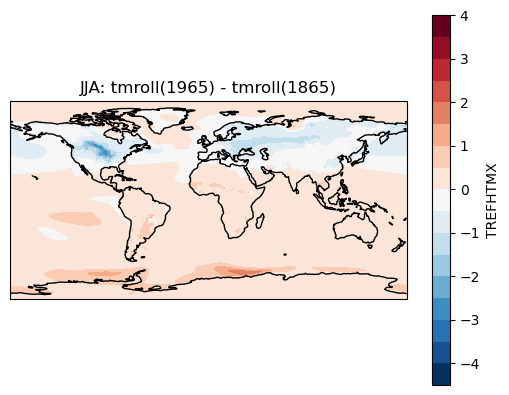

CPU times: user 5.74 s, sys: 644 ms, total: 6.38 s
Wall time: 30.5 s


In [30]:
%%time
###### Open and Plot  ##########
tgmw_season_mhano = xr.open_zarr(season_hanopath)
tgmw_season_mhano = tgmw_season_mhano.TREFHTMX
##### Plot #########
ax            = plt.axes(projection=cart.crs.PlateCarree())
tgmw_season_mhano.plot.contourf(ax=ax,transform=cart.crs.PlateCarree(),\
                                            levels=np.arange(-4.5,4.5,0.5))
ax.coastlines(color="black")
#plt.title('q=0.9,'+r'$\delta t_w - \delta t_{msc}$')
# plt.plot(-87.629,41.94,marker='*',color='tab:orange')
# plt.plot(77.5,12.72,marker='*',color='tab:brown')
plt.xlabel('lon')
plt.ylabel('lat')
plt.title(season+': tmroll(1965) - tmroll(1865)')
#plt.title('')
plt.show()

In [31]:
%%time
tgmw_d  = to_daily(tgmw)
tgmw_d0 = tgmw_d.sel(year=slice(1850,1879))
tgmw_d1 = tgmw_d.sel(year=slice(1950,1979))
tgmw_d0

CPU times: user 209 ms, sys: 12.1 ms, total: 221 ms
Wall time: 252 ms


/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/dataset.py:4880: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  result = result._unstack_full_reindex(


,Array,Chunk
Bytes,225.56 GiB,250.63 MiB
Shape,"(192, 288, 100, 30, 365)","(20, 30, 100, 3, 365)"
Count,66049 Tasks,1300 Chunks
Type,float32,numpy.ndarray


In [32]:
# tgnw_season  = tgnw.sel(time=tgnw.time.dt.month.isin(months)).chunk({'lat':20,'lon':30,'member':100})
# tgnw_season  = to_daily(tgnw_season)
# tgnw_season

In [33]:
# mah = mean annual and historical
tgmw_meand0 = tgmw_d0.mean({'day','year','member'})
tgmw_meand1 = tgmw_d1.mean({'day','year','member'})
tgmw_mahano = tgmw_meand1 - tgmw_meand0
tgmw_mahano

<xarray.DataArray 'TREFHTMX' (lat: 192, lon: 288)>
dask.array<sub, shape=(192, 288), dtype=float32, chunksize=(20, 30), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8

In [34]:
%%time
#Save files
annual_hanopath = cvals+'tgmw_hano_annual'+'_'+pi_year0+'_'+ic_year1+'.zarr'
print(annual_hanopath)
# ##### season ###########
#tgmw_mahano.to_dataset().to_zarr(annual_hanopath,mode='w')

/global/scratch/users/harsha/LENS/cesm2/cvals/tgmw_hano_annual_1850_1979.zarr
CPU times: user 754 µs, sys: 0 ns, total: 754 µs
Wall time: 585 µs


/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_string

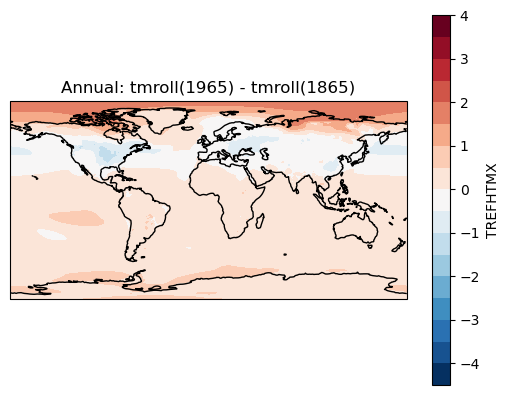

CPU times: user 1.3 s, sys: 83.5 ms, total: 1.38 s
Wall time: 1.56 s


In [35]:
%%time
###### Open and Plot  ##########
tgmw_mahano = xr.open_zarr(annual_hanopath)
tgmw_mahano = tgmw_mahano.TREFHTMX
##### Plot #########
ax            = plt.axes(projection=cart.crs.PlateCarree())
tgmw_mahano.plot.contourf(ax=ax,transform=cart.crs.PlateCarree(),\
                                            levels=np.arange(-4.5,4.5,0.5))
ax.coastlines(color="black")
#plt.title('q=0.9,'+r'$\delta t_w - \delta t_{msc}$')
# plt.plot(-87.629,41.94,marker='*',color='tab:orange')
# plt.plot(77.5,12.72,marker='*',color='tab:brown')
plt.xlabel('lon')
plt.ylabel('lat')
plt.title('Annual: tmroll(1965) - tmroll(1865)')
#plt.title('')
plt.show()

In [36]:
############ Check if CLT implies Gaussian ########

<xarray.DataArray 'TREFHTMX' (lat: 192, lon: 288, day: 365, ym: 3000)>
dask.array<reshape, shape=(192, 288, 365, 3000), dtype=float32, chunksize=(20, 30, 365, 300), chunktype=numpy.ndarray>
Coordinates:
    year     (ym) int64 1950 1950 1950 1950 1950 ... 1979 1979 1979 1979 1979
  * day      (day) int64 1 2 3 4 5 6 7 8 9 ... 358 359 360 361 362 363 364 365
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member   (ym) int64 0 1 2 3 4 5 6 7 8 9 10 ... 90 91 92 93 94 95 96 97 98 99
Dimensions without coordinates: ym
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K
CPU times: user 113 ms, sys: 20.4 ms, total: 133 ms
Wall time: 128 ms


/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/variable.py:1722: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  result = result._stack_once(dims, new_dim)


<xarray.DataArray 'TREFHTMX' (lat: 192, lon: 288, day: 365, ym: 1, index: 3000)>
dask.array<getitem, shape=(192, 288, 365, 1, 3000), dtype=float32, chunksize=(20, 30, 365, 1, 3000), chunktype=numpy.ndarray>
Coordinates:
    year     (ym) int64 1965
  * day      (day) int64 1 2 3 4 5 6 7 8 9 ... 358 359 360 361 362 363 364 365
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member   (ym) int64 0
Dimensions without coordinates: ym, index
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K

In [38]:
tgmw_d

,Array,Chunk
Bytes,451.13 GiB,250.63 MiB
Shape,"(192, 288, 100, 60, 365)","(20, 30, 100, 3, 365)"
Count,64749 Tasks,2500 Chunks
Type,float32,numpy.ndarray


In [ ]:
##############################################

In [ ]:
# %%time
# # #Add a dummy time dimension to tgnw after relabeling time as 'old_time'
# # ########## season ###########
# tgnw_season_stack = stacker2(tgnw_season)
# ###################################
# tgnw_season_stack0= tgnw_season_stack.expand_dims(dim={'ym':2}).\
#                  assign_coords(ym=('ym',[1865,2086]))
# ######### Rename 'ym' as mtime
# tgnw_season_stack0

In [ ]:
def mean_adj(ds_stack,ds_mroll):
    ds = (ds_stack - ds_stack.mean(dim='mtime')) + ds_mroll
    return ds

def mean_std_adj(ds_stack,ds_mroll,ds_sroll):
    ds = (ds_stack -ds_stack.mean(dim='mtime'))*(ds_sroll/ds_stack.std(dim='mtime'))\
          + ds_mroll
    return ds

In [ ]:
# %%time
# #############
# tgmc_season  = mean_adj(tgnw_season_stack0, tgmw_season_mroll)
# tgmsc_season = mean_std_adj(tgnw_season_stack0, tgmw_season_mroll,tgmw_season_sroll)
# #############
# tgmc_season

In [ ]:
# %%time
# #Save files
# tgmc_seasonpath = cvals+'tgmc_'+season0+'_'+pi_year0+'_'+ic_year1+'.zarr'
# print(tgmc_seasonpath)
# #tgmc_season.to_dataset().to_zarr(tgmc_seasonpath,mode='w')

In [ ]:
# %%time
# #Save files
# tgmsc_seasonpath = cvals+'tgmsc_'+season0+'_'+pi_year0+'_'+ic_year1+'.zarr'
# print(tgmsc_seasonpath)
# # tgmsc_season.to_dataset().to_zarr(tgmsc_seasonpath,mode='w')

In [ ]:
# %%time
# tgmc_season   = xr.open_zarr(tgmc_seasonpath)
# tgmc_season   = tgmc_season.TREFHTMX
# tgmsc_season  = xr.open_zarr(tgmsc_seasonpath)
# tgmsc_season  = tgmsc_season.TREFHTMX

In [ ]:
# %%time
# #### Compute quantiles 
# qgmc_season     = tgmc_season.chunk(dict(mtime=-1)).quantile(quants,dim='mtime',skipna=False)
# qgmsc_season    = tgmsc_season.chunk(dict(mtime=-1)).quantile(quants,dim='mtime',skipna=False)
# #####################
# qgmsc_season

In [ ]:
# %%time
# #Save all quantile functions
# qgmsc_seasonpath = cvals+'qgmsc_'+season0+'_'+pi_year0+'_'+ic_year1+'.zarr'
# qgmc_seasonpath  = cvals+'qgmc_'+season0+'_'+pi_year0+'_'+ic_year1+'.zarr'
# ####s
# print(qgmsc_seasonpath)

In [ ]:
#%%time
#qgmc_season.to_dataset().to_zarr(qgmc_seasonpath,mode='w')

In [ ]:
#%%time
#qgmsc_season.to_dataset().to_zarr(qgmsc_seasonpath,mode='w')

In [ ]:
# ##Open files and plot
# qgmc_season   = xr.open_zarr(qgmc_seasonpath)
# qgmsc_season  = xr.open_zarr(qgmsc_seasonpath) 
# qgmc_season   = qgmc_season.TREFHTMX
# qgmsc_season  = qgmsc_season.TREFHTMX
# qgmw_season   = qgmw_season.assign_coords({'ym':[1865,2086]})
# qgmc_season   = qgmc_season.assign_coords({'ym':[1865,2086]})
# qgmsc_season  = qgmsc_season.assign_coords({'ym':[1865,2086]})

In [ ]:
# %%time
# ######### Relative Differences/Errors #######
# qgmw_season_diff     = qgmw_season.sel(ym=1865)  - qgmw_season.sel(ym=2086)
# qgmc_season_diff     = qgmc_season.sel(ym=1865)  - qgmc_season.sel(ym=2086)
# qgmsc_season_diff    = qgmsc_season.sel(ym=1865) - qgmsc_season.sel(ym=2086)
# qgmw_season_reldiff1 = qgmw_season_diff - qgmc_season_diff
# qgmw_season_reldiff2 = qgmw_season_diff - qgmsc_season_diff
# qgmw_season_reldiff2

In [ ]:
# %%time
# ########### Save the absolute errors ############
# qgmw_season_diffpath      = cvals+'qgmw_'+season0+'_diff'+'_'+pi_year0+'_'+ic_year1+'.zarr'
# qgmw_season_reldiff1path  = cvals+'qgmw_'+season0+'_reldiff1'+'_'+pi_year0+'_'+ic_year1+'.zarr'
# qgmw_season_reldiff2path  = cvals+'qgmw_'+season0+'_reldiff2'+'_'+pi_year0+'_'+ic_year1+'.zarr'
# #### Save ########
# print(qgmw_season_diffpath)
# # qgmw_season_diff.to_dataset().to_zarr(qgmw_season_diffpath,mode='w')
# # qgmw_season_reldiff1.to_dataset().to_zarr(qgmw_season_reldiff1path,mode='w')
# # qgmw_season_reldiff2.to_dataset().to_zarr(qgmw_season_reldiff2path,mode='w')

In [ ]:
##### Open and plot ########
qgmw_season_diff     = xr.open_zarr(qgmw_season_diffpath)
qgmw_season_reldiff1 = xr.open_zarr(qgmw_season_reldiff1path)
qgmw_season_reldiff2 = xr.open_zarr(qgmw_season_reldiff2path)
qgmw_season_diff     = qgmw_season_diff.TREFHTMX
qgmw_season_reldiff1 = qgmw_season_reldiff1.TREFHTMX
qgmw_season_reldiff2 = qgmw_season_reldiff2.TREFHTMX

In [ ]:
def altspace(start, step, count, endpoint=False, **kwargs):
   stop = start+(step*count)
   return np.linspace(start, stop, count, endpoint=endpoint, **kwargs)

In [ ]:
#Get green, blue, red, and purple colormaps
green_cmap = cm.get_cmap('Greens')
blue_cmap = cm.get_cmap('RdBu_r')
red_cmap = cm.get_cmap('RdBu_r')
darkred_cmap = cm.get_cmap('spring')


# Create a list of 42 colors
colors = []

# Add 4 decreasing shades of green
green_range = np.linspace(1, 0.5, 8)
for i in green_range:
    colors.append(green_cmap(i))

# Add 16 decreasing shades of blue from RdBu
blue_range = np.linspace(0, 0.5, 16)
for i in blue_range:
    colors.append(blue_cmap(i))

# Add white color
colors.append((1, 1, 1, 1))

# Add 16 shades of red from RdBu
red_range = np.linspace(0.5, 1, 16)
for i in red_range:
    colors.append(red_cmap(i))

# Add 6 shades of dark_red
darkred_range = np.linspace(0.5, 1, 8)
for i in darkred_range:
    colors.append(darkred_cmap(i))

In [ ]:
len(colors)

In [ ]:
levs     = np.concatenate([altspace(-20.0,2.0,8),\
                           altspace(-4.0,0.25,32),altspace(4,2,9)])
levs

In [ ]:
len(levs)

In [ ]:
ticks    = np.concatenate([altspace(-20.0,3.0,6), altspace(-2.0,2,3),altspace(2,3,7)])
ticks

In [ ]:
################################
norm = mcolors.Normalize(-20,20)
# colors = [[norm(-19.0), "#76d154"],
#           [norm(-6.0), '#1fa187'],
#           [norm(-4.0),'royalblue'],
#           [norm( 0), "white"],
#           [norm( 4.0), rd_color],
#           [norm(19.0), 'purple']]
####################
colors0  = list(zip(norm(levs),colors))
cmap     = mcolors.LinearSegmentedColormap.from_list("mycmap", colors0)
cmap

In [ ]:
# Create ScalarMappable object
sm     = cm.ScalarMappable(cmap=cmap,norm=norm)
# Create colorbar with specified number of color bins in divergent part
cbar = plt.colorbar(sm, location='right', orientation='vertical',ticks=ticks)
plt.gca().set_visible(False)

In [ ]:
# levs     = np.concatenate([altspace(-19.0,3.0,4),\
#                            altspace(-4.0,0.25,32),altspace(4,3,6)])
# levs

In [ ]:
#np.min(qgmw_season_diff.sel(quantile=0.9)).values, np.max(qgmw_season_diff.sel(quantile=0.9)).values

In [ ]:
#np.min(qgmw_season_reldiff1.sel(quantile=0.9)).values, np.max(qgmw_season_reldiff1.sel(quantile=0.9)).values

In [ ]:
#np.min(qgmw_season_reldiff2.sel(quantile=0.9)).values, np.max(qgmw_season_reldiff2.sel(quantile=0.9)).values

In [ ]:
# %%time
# qgmw_season_diff.sel(quantile=0.9).where(qgmw_season_diff.sel(quantile=0.9)\
#                             ==qgmw_season_diff.sel(quantile=0.9).max(), drop=True).squeeze()

In [ ]:
# %%time
# qgmw_season_diff.sel(quantile=0.9).where(qgmw_season_diff.sel(quantile=0.9)\
#                             ==qgmw_season_diff.sel(quantile=0.9).min(), drop=True).squeeze()

In [ ]:
# %%time
# qgmw_season_reldiff1.sel(quantile=0.9).where(qgmw_season_reldiff1.sel(quantile=0.9)\
#                             ==qgmw_season_reldiff1.sel(quantile=0.9).max(), drop=True).squeeze()

In [ ]:
%%time
#Quantile q=0.1
#Plot 3a
ax       = plt.axes(projection=cart.crs.PlateCarree())
qgmw_season_diff.sel(quantile=0.9,day=day).plot(ax=ax,transform=cart.crs.PlateCarree(),\
                                                             cmap=cmap,norm=norm)
plt.plot(-87.629,41.94,marker='*',color='tab:orange')
plt.plot(77.5,12.72,marker='*',color='tab:brown')
ax.coastlines(color="black")
plt.title(Day+':Tmax, q=0.9, pi - actual')
plt.show()

In [ ]:
%%time
#PLot 3b
ax            = plt.axes(projection=cart.crs.PlateCarree())
qgmw_season_reldiff1.sel(quantile=0.9,day=day).plot(ax=ax,transform=cart.crs.PlateCarree(),\
                                                              cmap=cmap,norm=norm,cbar_kwargs={'ticks':ticks})
#plt.colorbar(sm,ax=ax,norm=norm)
plt.plot(-87.629,41.94,marker='*',color='tab:orange')
plt.plot(77.5,12.72,marker='*',color='tab:brown')
ax.coastlines(color="black")
#plt.title(Day+',q=0.9,'+r'$\delta t_w - 0$')
plt.title(Day+':Tmax, q=0.9, (pi + shift) - actual')
plt.show()

In [ ]:
%%time
#PLot 3c
ax            = plt.axes(projection=cart.crs.PlateCarree())
qgmw_season_reldiff2.sel(quantile=0.9,day=day).plot(ax=ax,transform=cart.crs.PlateCarree(),\
                                                              cmap=cmap,norm=norm,cbar_kwargs={'ticks':ticks})
#plt.colorbar(sm,ax=ax,norm=norm)
plt.plot(-87.629,41.94,marker='*',color='tab:orange')
plt.plot(77.5,12.72,marker='*',color='tab:brown')
ax.coastlines(color="black")
#plt.title(Day+',q=0.9,'+r'$\delta t_w - 0$')
plt.title(Day+':Tmax, q=0.9, (pi + shift + stretch) - actual')
plt.show()

In [ ]:
################ seasonal plots  ###########

In [ ]:
%%time
#Plot 4a
ax       = plt.axes(projection=cart.crs.PlateCarree())
qgmw_season_diff.sel(quantile=0.9).mean({'day'}).plot(ax=ax,transform=cart.crs.PlateCarree(),\
                                                     add_colorbar=False,cmap=cmap,norm=norm)
#plt.colorbar(sm,ax=ax,norm=norm)
plt.plot(-87.629,41.94,marker='*',color='tab:orange')
plt.plot(77.5,12.72,marker='*',color='tab:brown')
ax.coastlines(color="black")
#plt.title(Day+',q=0.9,'+r'$\delta t_w - 0$')
#plt.title('q=0.9, pi - actual, '+ season+' mean')
plt.title('')
plt.show()

In [ ]:
%%time
#PLot 4b
ax            = plt.axes(projection=cart.crs.PlateCarree())
qgmw_season_reldiff1.sel(quantile=0.9).mean({'day'}).plot(ax=ax,transform=cart.crs.PlateCarree(),
                                                          add_colorbar=False,cmap=cmap,norm=norm)
plt.plot(-87.629,41.94,marker='*',color='tab:orange')
plt.plot(77.5,12.72,marker='*',color='tab:brown')
ax.coastlines(color="black")
#plt.title('q=0.9, (pi + shift) - actual, '+ season +' mean')
plt.title('')
plt.show()

In [ ]:
%%time
#PLot 4c
ax            = plt.axes(projection=cart.crs.PlateCarree())
qgmw_season_reldiff2.sel(quantile=0.9).mean({'day'}).plot(ax=ax,transform=cart.crs.PlateCarree(),\
                                                         cmap=cmap,norm=norm)
plt.plot(-87.629,41.94,marker='*',color='tab:orange')
plt.plot(77.5,12.72,marker='*',color='tab:brown')
ax.coastlines(color="black")
#plt.title(Day+',q=0.9,'+r'$\delta t_w - 0$')
#plt.title('q=0.9, (pi + shift + stretch) - actual, '+ season +' mean')
plt.title('')
plt.show()

In [ ]:
# Take a zonal average (weighted mean over longitude)

In [ ]:
weights      = np.cos(np.deg2rad(qgmw_season_diff.lat))
weights.name = "weights"

In [ ]:
%%time
qgmw_season_diffw            = qgmw_season_diff.weighted(weights)
qgmw_season_reldiff1w        = qgmw_season_reldiff1.weighted(weights)
qgmw_season_reldiff2w        = qgmw_season_reldiff2.weighted(weights)

In [ ]:
qgmw_season_zmean     = qgmw_season_diffw.mean('lon')
qgmc_season_zmean     = qgmw_season_reldiff1w.mean('lon')
qgmsc_season_zmean    = qgmw_season_reldiff2w.mean('lon')

In [ ]:
qgmw_season_zme     = qgmw_season_zmean.mean('day')
qgmc_season_zme     = qgmc_season_zmean.mean('day')
qgmsc_season_zme    = qgmsc_season_zmean.mean('day')
qgmsc_season_zme    

In [ ]:
%%time
qgmw_season_zmepath  = cvals+'qgmw_'+season0+'_zme'+'_'+pi_year0+'_'+ic_year1+'.zarr'
qgmc_season_zmepath  = cvals+'qgmc_'+season0+'_zme'+'_'+pi_year0+'_'+ic_year1+'.zarr'
qgmsc_season_zmepath = cvals+'qgmsc_'+season0+'_zme'+'_'+pi_year0+'_'+ic_year1+'.zarr'
##########################
qgmw_season_zme.to_dataset().to_zarr(qgmw_season_zmepath,mode='w')
qgmc_season_zme.to_dataset().to_zarr(qgmc_season_zmepath,mode='w')
qgmsc_season_zme.to_dataset().to_zarr(qgmsc_season_zmepath,mode='w')

In [ ]:
qgmw_season_zmepath   = xr.open_zarr(qgmw_season_zmepath)
qgmc_season_zmepath   = xr.open_zarr(qgmc_season_zmepath)
qgmsc_season_zmepath  = xr.open_zarr(qgmsc_season_zmepath)
qgmw_season_zmepath   = qgmw_season_zmepath.TREFHTMX
qgmc_season_zmepath   = qgmc_season_zmepath.TREFHTMX
qgmsc_season_zmepath  = qgmsc_season_zmepath.TREFHTMX

In [ ]:
qgmw_season_zmepath.plot(x='quantile',y='lat',cmap=cmap,norm=norm,cbar_kwargs={'ticks':ticks})
plt.title(season + ':zonal mean, pi- actual')

In [ ]:
qgmc_season_zmepath.plot(x='quantile',y='lat',cmap=cmap,norm=norm,cbar_kwargs={'ticks':ticks})
plt.title(season + ', zonal mean: pi- shift')

In [ ]:
qgmsc_season_zmepath.plot(x='quantile',y='lat',cmap=cmap,norm=norm,cbar_kwargs={'ticks':ticks})
plt.title(season + ', zonal mean: pi- (shift + stretch)')

In [ ]:
# %%time
# #PLot 4c
# ax            = plt.axes(projection=cart.crs.PlateCarree())
# qgmw_season_zme.plot(ax=ax,transform=cart.crs.PlateCarree())
# ax.coastlines(color="black")
# plt.title('Zonal mean')
# plt.show()

In [ ]:
############# Compute area-weighted mean square of the above errors #####################

In [ ]:
qgmw_season_esq  = qgmw_season_diff**2
qgmc_season_esq  = qgmw_season_reldiff1**2
qgmsc_season_esq = qgmw_season_reldiff2**2

In [ ]:
weights      = np.cos(np.deg2rad(qgmw_season_esq.lat))
weights.name = "weights"

In [ ]:
qgmw_seasonserror_weighted  = qgmw_season_esq.weighted(weights)
qgmc_seasonserror_weighted  = qgmc_season_esq.weighted(weights)
qgmsc_seasonserror_weighted = qgmsc_season_esq.weighted(weights)
qgmc_season_esq

In [ ]:
qgmw_seasonserror_gmean   = qgmw_seasonserror_weighted.mean({'lat','lon'})
qgmc_seasonserror_gmean   = qgmc_seasonserror_weighted.mean({'lat','lon'})
qgmsc_seasonserror_gmean  = qgmsc_seasonserror_weighted.mean({'lat','lon'})
qgmc_seasonserror_gmean

In [ ]:
qgmw_season_gmse   = qgmw_seasonserror_gmean.mean({'day'})
qgmc_season_gmse   = qgmc_seasonserror_gmean.mean({'day'})
qgmsc_season_gmse  = qgmsc_seasonserror_gmean.mean({'day'})
qgmc_season_gmse

In [ ]:
%%time
qgmw_season_grmse         = np.sqrt(qgmw_season_gmse)
qgmc_season_grmse         = np.sqrt(qgmc_season_gmse)
qgmsc_season_grmse        = np.sqrt(qgmsc_season_gmse)

In [ ]:
%%time
qgmw_season_grmsepath  = cvals+'qgmw_'+season0+'_grmse'+'_'+pi_year0+'_'+ic_year1+'.zarr'
qgmc_season_grmsepath  = cvals+'qgmc_'+season0+'_grmse'+'_'+pi_year0+'_'+ic_year1+'.zarr'
qgmsc_season_grmsepath = cvals+'qgmsc_'+season0+'_grmse'+'_'+pi_year0+'_'+ic_year1+'.zarr'
##########################
# qgmw_season_grmse.to_dataset().to_zarr(qgmw_season_grmsepath,mode='w')
# qgmc_season_grmse.to_dataset().to_zarr(qgmc_season_grmsepath,mode='w')
# qgmsc_season_grmse.to_dataset().to_zarr(qgmsc_season_grmsepath,mode='w')

In [ ]:
%%time
qgmw_season_grmse  = xr.open_zarr(qgmw_season_grmsepath)
qgmc_season_grmse  = xr.open_zarr(qgmc_season_grmsepath)
qgmsc_season_grmse = xr.open_zarr(qgmsc_season_grmsepath)
qgmw_season_grmse  = qgmw_season_grmse.TREFHTMX
qgmc_season_grmse  = qgmc_season_grmse.TREFHTMX
qgmsc_season_grmse  = qgmsc_season_grmse.TREFHTMX

In [ ]:
%%time
plt.plot(quants,qgmw_season_grmse,label='pi')
plt.plot(quants,qgmc_season_grmse,label='pi + shift',c='tab:orange')
plt.plot(quants,qgmsc_season_grmse,label='pi + shift + stretch',c='tab:green')
plt.legend(loc='center')
plt.title('CESM2: Global,seasonal RMSEs-'+season)
plt.ylabel('Tmax (K)')
plt.xlabel('Percentiles')
plt.show()

In [ ]:
%%time
season_error_redn = qgmsc_season_grmse.integrate('quantile')/qgmc_season_grmse.integrate('quantile')
season_error_redn.values

In [ ]:
qgmsc_season_grmse.integrate('quantile').values

In [ ]:
qgmc_season_grmse.integrate('quantile').values

In [ ]:
qgmsc_season_grmse.where(qgmsc_season_grmse<0.5).values

In [ ]:
qgmsc_season_grmse.where(qgmsc_season_grmse<1).values